In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


导入数据集，并查看数据集基本信息

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv",header=0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv",header=0)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


数值型数据的描述性统计分析

In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


为了方便后面建立特征工程，结合统计学知识和可视化进行变量间的相关性分析

In [5]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

1、Sex：乘客性别
可视化结果分析：对比来说，女性的生存几率远高于男性。
因此最终模型中需包含此特征

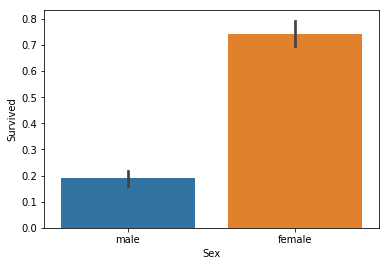

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x = 'Sex', y = 'Survived',data = train_data)

2、Pclass 船票等级，1为最高等级
可视化结果分析：船票等级越高，乘客生还率越高
因此最终模型中也需要包括此特征。

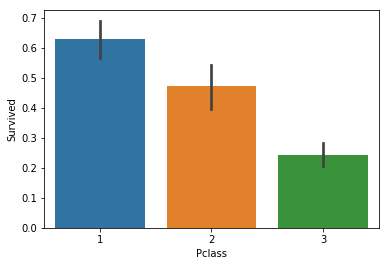

In [7]:
sns.barplot(x = 'Pclass',y = 'Survived',data = train_data)

3、Age 年龄
可视化结果：可以看到Age对生还率同样有着一定的影响
可以考虑将Age放入特征集中

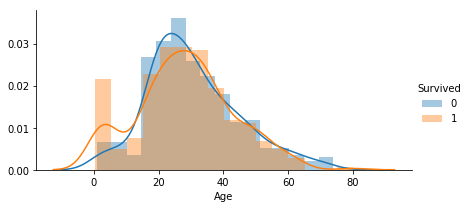

In [8]:
g = sns.FacetGrid(train_data, hue="Survived",aspect=2)
g.map(sns.distplot,"Age")
g.add_legend()

4、SibSp （同时登船的兄弟姐妹/配偶的人数) 及 Parch(同时登船的父母/子女人数）
可视化结果：可以看到两者均在中等数量时有着较高的生还几率
另外，这两个变量相似性比较高，可以考虑合并为一个特征值。

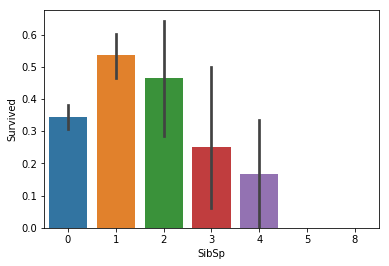

In [9]:
sns.barplot(x = 'SibSp',y = 'Survived',data = train_data)

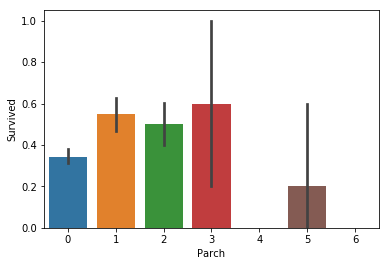

In [10]:
sns.barplot(x = 'Parch',y = 'Survived',data = train_data)

5、Embarked 登船港口
可视化结果：在C地的登船港口登船的乘客生存几率更高
因此在构建模型时也需要加入此特征

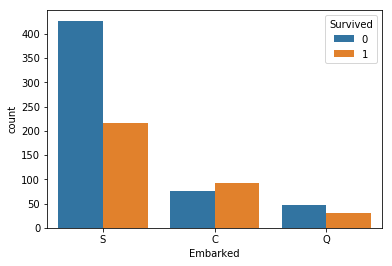

In [11]:
sns.countplot(x = 'Embarked',hue = 'Survived',data = train_data)

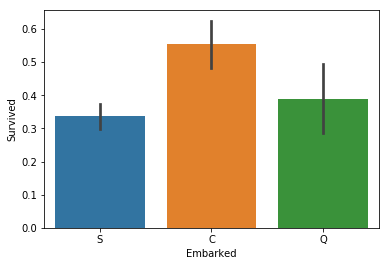

In [12]:
sns.barplot(x = 'Embarked',y = 'Survived',data = train_data)

6、其他因素：除以上的因素，还有乘客姓名，船票价格，船票号，船舱号，这些因素中包含着乘客的社会地位，所处位置等，均可能对乘客生还率有着一定的影响，如果要对这些因素进行分析，需要再进行细致的处理，此处暂时不对这些因素进行处理。

**特征工程**
为了将训练集和测试集内的数据进行处理，首先将两个数据集进行合并

In [13]:
all_data = pd.concat([train_data,test_data],ignore_index = True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


1、Sex 性别
将此特征数字化处理

In [14]:
all_data = pd.get_dummies(all_data,columns=["Sex"])
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Sex_female,Sex_male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,1,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,1.0,STON/O2. 3101282,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1.0,113803,1,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0.0,373450,0,1


2、将Pclass进行哑变量化处理

In [15]:
all_data = pd.get_dummies(all_data,columns=['Pclass'])
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,1,0,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,1,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,0,0,0,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,0,1,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,1,0,0,1


3、将SibSp和Parch两个特征通过求和进行合并,接下来按照不同的FamilyFeature将其分为三类，因为在进行训练和预测时不需要数值，只需要看家庭成员的规模即可。

In [16]:
all_data['FamilyFeature'] = all_data['SibSp'] + all_data['Parch'] 

In [17]:
def Fam_scale(f):
    if (f >= 1) & (f <= 3):
        return 2
    elif ((f >= 4) & (f <= 6)) | (f == 0):
        return 1
    elif (f > 6):
        return 0
    
all_data['FamilyLabel'] = all_data['FamilyFeature'].apply(Fam_scale)
all_data = pd.get_dummies(all_data,columns=['FamilyLabel'])
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,FamilyFeature,FamilyLabel_0,FamilyLabel_1,FamilyLabel_2
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,1,0,0,1,1,0,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,1,0,0,1,0,0,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,0,0,0,1,0,0,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,0,1,0,0,1,0,0,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,1,0,0,1,0,0,1,0


4、Embarked 登船港口
有两个缺失值，具体看一下这两个缺失值的情况，可以看到这两个缺失值数据均是生存率为1的，且Pclass等级为1，根据之前分析的情况，登船港口的可能性为C的可能性最大， 因此将这两个缺失值填充为C,并将其数值化

In [18]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,FamilyFeature,FamilyLabel_0,FamilyLabel_1,FamilyLabel_2
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,0,1.0,113572,1,0,1,0,0,0,0,1,0
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,0,1.0,113572,1,0,1,0,0,0,0,1,0


In [19]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')
all_data = pd.get_dummies(all_data,columns=['Embarked'])
all_data.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Sex_female,...,Pclass_1,Pclass_2,Pclass_3,FamilyFeature,FamilyLabel_0,FamilyLabel_1,FamilyLabel_2,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,...,0,0,1,1,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,...,1,0,0,1,0,0,1,1,0,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,...,0,0,1,0,0,1,0,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,...,1,0,0,1,0,0,1,0,0,1
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,...,0,0,1,0,0,1,0,0,0,1


5、Name 姓名
这个特征中包括了一些对乘客的共性称呼，例如Mr,Miss,Master等,通过这些关键字分为6类，然后进行数值化处理

In [20]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

all_data['Title'] = all_data['Title'].map(Title_Dict)
all_data.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Sex_female,...,Pclass_2,Pclass_3,FamilyFeature,FamilyLabel_0,FamilyLabel_1,FamilyLabel_2,Embarked_C,Embarked_Q,Embarked_S,Title
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,...,0,1,1,0,0,1,0,0,1,Mr
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,...,0,0,1,0,0,1,1,0,0,Mrs
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,1,...,0,1,0,0,1,0,0,0,1,Miss
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,...,0,0,1,0,0,1,0,0,1,Mrs
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,...,0,1,0,0,1,0,0,0,1,Mr


In [21]:
all_data = pd.get_dummies(all_data,columns=['Title'])

6、Fare 票价
这个特征在test测试集有一个缺失值，查看缺失值情况，可以看到该缺失值的Pclass为3级，Embarked为S，因此取这个等级的平均值进行填充

In [22]:
all_data[all_data['Fare'].isnull()]['Pclass_3']

1043    1
Name: Pclass_3, dtype: uint8

In [23]:
train_data.groupby(["Pclass","Embarked"])['Fare'].mean()

Pclass  Embarked
1       C           104.718529
        Q            90.000000
        S            70.364862
2       C            25.358335
        Q            12.350000
        S            20.327439
3       C            11.214083
        Q            11.183393
        S            14.644083
Name: Fare, dtype: float64

In [24]:
all_data['Fare'] = all_data['Fare'].fillna(14.64)

In [25]:
all_data.isnull().any()

Age               True
Cabin             True
Fare             False
Name             False
Parch            False
PassengerId      False
SibSp            False
Survived          True
Ticket           False
Sex_female       False
Sex_male         False
Pclass_1         False
Pclass_2         False
Pclass_3         False
FamilyFeature    False
FamilyLabel_0    False
FamilyLabel_1    False
FamilyLabel_2    False
Embarked_C       False
Embarked_Q       False
Embarked_S       False
Title_Master     False
Title_Miss       False
Title_Mr         False
Title_Mrs        False
Title_Officer    False
Title_Royalty    False
dtype: bool

7、Ticket 票号
这个暂时不进行处理，也不进行使用

In [26]:
all_data.drop('Ticket',axis=1,inplace=True)

8、Age 年龄 
这个特征缺失值比较多，共263个缺失值，可以考虑使用机器学习算法对Age进行预测。

In [27]:
all_data.drop('Age',axis=1,inplace=True)

9、Cabin 

In [28]:
all_data.drop('Cabin',axis=1,inplace=True)

In [29]:
all_data.drop('Name',axis=1,inplace=True)

In [30]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
Fare             1309 non-null float64
Parch            1309 non-null int64
PassengerId      1309 non-null int64
SibSp            1309 non-null int64
Survived         891 non-null float64
Sex_female       1309 non-null uint8
Sex_male         1309 non-null uint8
Pclass_1         1309 non-null uint8
Pclass_2         1309 non-null uint8
Pclass_3         1309 non-null uint8
FamilyFeature    1309 non-null int64
FamilyLabel_0    1309 non-null uint8
FamilyLabel_1    1309 non-null uint8
FamilyLabel_2    1309 non-null uint8
Embarked_C       1309 non-null uint8
Embarked_Q       1309 non-null uint8
Embarked_S       1309 non-null uint8
Title_Master     1309 non-null uint8
Title_Miss       1309 non-null uint8
Title_Mr         1309 non-null uint8
Title_Mrs        1309 non-null uint8
Title_Officer    1309 non-null uint8
Title_Royalty    1309 non-null uint8
dtypes: float64(2), int64(4), uint8(17)

10、划分数据集

In [31]:
train_data = all_data[all_data['Survived'].notnull()]
test_data = all_data[all_data['Survived'].isnull()]
train_X =  train_data.drop(['Survived'],axis=1)
train_Y = train_data['Survived']
test_X = test_data.drop(['Survived'],axis=1)

In [32]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=150,min_samples_leaf=2,max_depth=6,oob_score=True)
RF.fit(train_X,train_Y)
RF.oob_score_

0.8282828282828283

In [33]:
predictions= RF.predict(test_X)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
